<a href="https://colab.research.google.com/github/Maxibrionest/MachineLearning/blob/main/Entrega3/Entrega3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning, caso de estudio Monopoly/Dormammu**

Nombre: Maximiliano Briones / Lucas Vásquez

Sección: 003V

Evaluación: 3

Fecha de entrega: 01/12/2021

---


# **Fase I. Business Understanding.**

El banco "Monopoly" fue adquirido recientemente por el banco, con capitales extranjeros, "Dormammu". Éste encargó hacer estudios sobre la adquisición, determinando  comportamiento, patrones y una estrategia para abordar a los nuevos clientes.

En este estudio debemos presentar un análisis mediante aprendizaje no supervisado, seleccionando el modelo que presente mejores resultados en predicción y que su selección sea respaldada y justificada.


[Link a enunciado original](https://github.com/Maxibrionest/MachineLearning/blob/main/Entrega1/ET221_3A_MLY0100.docx).

# **Fase II. Data Understanding.**

> A continuación, se importan las librerías a utilizar.

In [121]:
#Librerías
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import time
#Preprocesamiento
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#Imputación
from sklearn.impute import KNNImputer
#Estandarización
from sklearn.preprocessing import StandardScaler
#Normalización
from sklearn.preprocessing import MinMaxScaler
#Modelos Y Métricas
from sklearn.cluster import KMeans
#Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
#PCA
from sklearn.decomposition import PCA
#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
#Silhoutte
from sklearn.metrics import silhouette_score
#KNeighbors
from sklearn.neighbors import NearestNeighbors


> Carga de Base de datos a través de Google Drive

In [95]:
#from google.colab import drive
#drive.mount('/gdrive')

In [14]:
sheetname = 'Transición de Negocio'
path_to_file = r'C:\Users\brion\Downloads\Base_clientes_Monopoly.xlsx'
df = pd.read_excel(path_to_file, sheet_name=sheetname, header=1)

In [15]:
df

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target,Unnamed: 574
0,1,160,M,13.0,43,NaN,130,1,1,0,...,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0,NaN
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0,NaN
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0,NaN
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0,NaN
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,...,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0,NaN
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,...,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0,NaN
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,...,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0,NaN
51122,51123,160,M,13.0,47,NaN,11,1,0,0,...,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,0,NaN


**Como sabemos los datos corresponden a un excel con actividad financiera de clientes del banco Monopoly, contiene una muestra de clientes con 12 meses de información almacenada en variables mensuales por cada cliente.**

In [16]:
#
print("Cantidad de observaciones: ", df.shape[0])
print("Cantidad de columnas:      ", df.shape[1])
print("Cantidad de datos:         ", df.shape[0] * df.shape[1])
observaciones = df.shape[0]

Cantidad de observaciones:  51124
Cantidad de columnas:       575
Cantidad de datos:          29396300


**Estamos frente un dataset grande superando los 29 millones de datos u observaciones. Pero como se mencionó, más adelante estaremos separando la data y quedándonos solo con lo que nos interesa y consideramos pertiente, por lo que es probable que ese número total disminuya en buena medida.**

In [17]:
df.dtypes

Id                int64
Subsegmento       int64
Sexo             object
Region          float64
Edad              int64
                 ...   
UsoL2_T01         int64
UsoLI_T01       float64
IndRev_T01       object
target            int64
Unnamed: 574    float64
Length: 575, dtype: object

**Al revisar los tipos de datos vemos que si hay ciertos datos que  son de tipo object y estos podrán ocacionarnos algún error, por lo que más adelante los estaremos transformando con OneHotEncoder.**

In [18]:
df.describe()

,Id,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,target,Unnamed: 574
count,51124.000000,51124.000000,51071.000000,51124.000000,3.775900e+04,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,...,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,51124.000000,5.112400e+04,5.112400e+04,51124.000000,51124.000000,0.0
mean,25562.500000,182.024274,10.828220,38.702879,6.630771e+05,38.896154,0.684199,0.256181,0.381347,0.063141,...,5.237914e+03,7.637553e+04,1.734930e+03,1.939488e+05,7.323155,1.840923e+05,1.360327e+05,8.294372,0.089977,NaN
std,14758.371918,29.276596,3.392703,13.302573,4.092795e+05,35.672549,0.464839,0.436527,0.485722,0.243218,...,4.852871e+04,1.490256e+05,4.235368e+04,2.884980e+05,108.161194,2.891731e+05,4.325389e+05,113.215624,0.286152,NaN
min,1.000000,151.000000,1.000000,9.000000,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.861866e+06,-7886.760000,-3.763997e+06,-4.000000e+00,-7785.120000,0.000000,NaN
25%,12781.750000,160.000000,9.000000,28.000000,4.199990e+05,14.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,5.000000e+03,0.000000e+00,3.198100e+04,0.000000,1.770750e+04,0.000000e+00,0.000000,0.000000,NaN
50%,25562.500000,170.000000,13.000000,35.000000,5.670120e+05,25.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000e+00,3.400150e+04,0.000000e+00,9.223050e+04,0.000000,8.112900e+04,2.964650e+04,0.000000,0.000000,NaN
75%,38343.250000,210.000000,13.000000,46.000000,8.149035e+05,54.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000e+00,9.200000e+04,0.000000e+00,2.359780e+05,0.000000,2.278145e+05,1.021022e+05,0.000000,0.000000,NaN
max,51124.000000,959.000000,13.000000,104.000000,1.308933e+07,324.000000,1.000000,1.000000,1.000000,1.000000,...,2.072818e+06,8.697782e+06,4.219680e+06,6.911556e+06,3929.810000,6.911556e+06,1.178549e+07,3929.810000,1.000000,NaN


**La función describe nos permite ver la información estadistica de nuestro dataset, a simple vista podemos notar que la data está más agrupada hacia los últimos cuartiles.**

In [19]:
df.isnull().sum()

Id                  0
Subsegmento         0
Sexo                1
Region             53
Edad                0
                ...  
UsoL2_T01           0
UsoLI_T01           0
IndRev_T01          0
target              0
Unnamed: 574    51124
Length: 575, dtype: int64

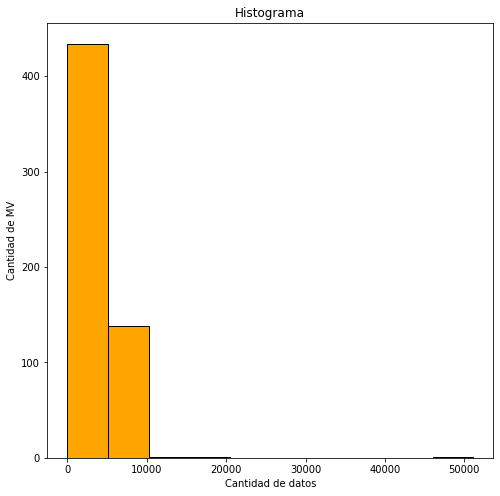

In [20]:
y = df.isna().sum()
num_bins = 10
plt.figure(figsize=(8,8))
plt.hist(y, num_bins, color="orange" , edgecolor='black')
plt.xlabel('Cantidad de datos')
plt.ylabel('Cantidad de MV')
plt.title('Histograma')
plt.show()

**Vemos que hay una gran número de filas con datos nulos en nuestro dataset, sin embargo hay una cantidad importante también de columnas las cuales no tienen datos nulos, por lo que más adelante estaremos separando la data y se curará para quedarnos con la menor cantidad de datos nulos, para no tener que "Inventar" data aplicando imputación.**


# **Fase III. Data Preparation**



Comenzamos a revisar los datos y darnos cuenta de lo que será útil y lo que no para más adelante.


In [21]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01', 'UsoL1_T01',
       'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target', 'Unnamed: 574'],
      dtype='object', length=575)

Al ver el excel, existe una suma que da cuenta de la cantidad de columnas y que está en la misma altura que los headers de las columnas, por lo que se eliminará al no aportar valor está columna está denonimada "Unnamed"

In [22]:
#Usamos la función drop para eliminar la columna anteriormente mencionada
df = df.drop(columns=['Unnamed: 574'])

### Aplicando OneHotEnconder



> Con los aprendizajes del analisis anterior, en primera instancia despejamos los valores no numéricos usando OneHotEncoder



In [23]:
df_0 = df.copy()
cols_a_cambiar = []
helper_0 = df_0.dtypes.to_frame()
helper_0 = helper_0.rename({0:'values'}, axis=1)

In [24]:
helper_0[helper_0.values == 'object']

,values
Sexo,object
IndRev_T12,object
IndRev_T11,object
IndRev_T10,object
IndRev_T09,object
IndRev_T08,object
IndRev_T07,object
IndRev_T06,object
IndRev_T05,object
IndRev_T04,object


In [25]:
helper_0[helper_0.values == 'object'].index

Index(['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09',
       'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04',
       'IndRev_T03', 'IndRev_T02', 'IndRev_T01'],
      dtype='object')

In [26]:
print(df_0[helper_0[helper_0.values == 'object'].index].Sexo.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T12.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T11.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T10.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T09.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T08.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T12.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T07.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T06.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T05.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T04.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T03.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T02.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T01.unique())

['M' 'H' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' nan 'P']
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P']




> Para los valores categóricos se contaron los MV



<AxesSubplot:>

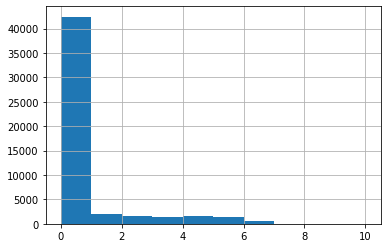

In [27]:
df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1).hist()

In [28]:
s = df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1)
agrupados = s.groupby(s)
agrupados = agrupados.size().to_frame()
agrupados = agrupados.rename({0:'values'}, axis=1)
agrupados

,values
0,42422
1,2029
2,1543
3,1442
4,1622
5,1371
6,656
7,22
8,9
9,5


In [29]:
agrupados['suma_acumulativa'] = agrupados['values'].cumsum()
agrupados['precentil_acumulativo'] = round(100*agrupados['suma_acumulativa']/agrupados['values'].sum(),3)
agrupados

,values,suma_acumulativa,precentil_acumulativo
0,42422,42422,82.979
1,2029,44451,86.947
2,1543,45994,89.966
3,1442,47436,92.786
4,1622,49058,95.959
5,1371,50429,98.641
6,656,51085,99.924
7,22,51107,99.967
8,9,51116,99.984
9,5,51121,99.994


> Con el objetivo de imputar la menor cantidad de data posible al mismo tiempo que se mantiene la cantidad de datos, se decidió por cortar y continuar usando todas las observaciones que tuviesen hasta 1 MV en algunas de las columnas categóricas, lo que conserva el 86.947% de los datos originales.

In [30]:
limpiar_0 = df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1).to_frame()
limpiar_0 = limpiar_0.rename({0:'values'}, axis=1)
df_0.drop(limpiar_0[limpiar_0.values > 2].index, inplace=True)

In [31]:
df_0

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,...,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,...,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,...,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0
51122,51123,160,M,13.0,47,NaN,11,1,0,0,...,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,0


> Se prepararán los categóricos usando OneHotEncoder

In [32]:
enc = OneHotEncoder()
data_encoder = enc.fit_transform(df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']])
dat = data_encoder.toarray()

In [33]:
enc.get_feature_names_out()

array(['Sexo_H', 'Sexo_M', 'IndRev_T12_P', 'IndRev_T12_R', 'IndRev_T12_T',
       'IndRev_T12_nan', 'IndRev_T11_P', 'IndRev_T11_R', 'IndRev_T11_T',
       'IndRev_T11_nan', 'IndRev_T10_P', 'IndRev_T10_R', 'IndRev_T10_T',
       'IndRev_T10_nan', 'IndRev_T09_P', 'IndRev_T09_R', 'IndRev_T09_T',
       'IndRev_T09_nan', 'IndRev_T08_P', 'IndRev_T08_R', 'IndRev_T08_T',
       'IndRev_T08_nan', 'IndRev_T07_P', 'IndRev_T07_R', 'IndRev_T07_T',
       'IndRev_T07_nan', 'IndRev_T06_P', 'IndRev_T06_R', 'IndRev_T06_T',
       'IndRev_T06_nan', 'IndRev_T05_P', 'IndRev_T05_R', 'IndRev_T05_T',
       'IndRev_T05_nan', 'IndRev_T04_P', 'IndRev_T04_R', 'IndRev_T04_T',
       'IndRev_T04_nan', 'IndRev_T03_P', 'IndRev_T03_R', 'IndRev_T03_T',
       'IndRev_T03_nan', 'IndRev_T02_P', 'IndRev_T02_R', 'IndRev_T02_T',
       'IndRev_T02_nan', 'IndRev_T01_P', 'IndRev_T01_R', 'IndRev_T01_T'],
      dtype=object)

> Se obtiene un dataframe con los datos encodeados.

In [34]:
df_enc = pd.DataFrame(dat, columns=enc.get_feature_names_out())
df_enc

,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T12_nan,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T11_nan,...,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [35]:
df_0 = df_0.reset_index()
df_0 = df_0.join(df_enc)
df_0 = df_0.drop(columns=['Id', 'Sexo'])
df_0

,index,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,...,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,0,160,13.0,43,NaN,130,1,1,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,160,13.0,46,143640.0,69,1,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,170,13.0,45,929106.0,24,1,1,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,151,13.0,46,172447.0,134,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,170,13.0,46,805250.0,116,0,1,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,51119,160,13.0,51,364978.0,57,1,1,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,51120,170,13.0,51,625376.0,39,1,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,51121,160,13.0,47,806220.0,153,1,1,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,51122,160,13.0,47,NaN,11,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [36]:
df_0.drop(columns=["index"], inplace=True)


> Se eliminan los features sin el encoding.

In [37]:
df_0 = df_0.drop(columns=['IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01'])
df_0.dtypes

Subsegmento         int64
Region            float64
Edad                int64
Renta             float64
Antiguedad          int64
                   ...   
IndRev_T02_T      float64
IndRev_T02_nan    float64
IndRev_T01_P      float64
IndRev_T01_R      float64
IndRev_T01_T      float64
Length: 609, dtype: object

> Se utiliza KNN Imputer para el imputado de datos

In [38]:
knn_imputer_0 = KNNImputer(n_neighbors=4, weights="uniform")
df_0[enc.get_feature_names_out()] = knn_imputer_0.fit_transform(df_0[enc.get_feature_names_out()])

In [39]:
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Se eliminan las columnas encodeadas que significaban nan

In [40]:
cols_nan = []
for i in df_0.columns:
  if i[-4:] == "_nan":
    cols_nan.append(i)
#print(cols_nan)
df_0 = df_0.drop(columns=(cols_nan))
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [41]:
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


Volviendo a revisar MV:

In [42]:
df_1 = df_0.copy()
s = df_1.isna().sum(axis=1)
agrupados = s.groupby(s)
agrupados = agrupados.size().to_frame()
agrupados = agrupados.rename({0:'values'}, axis=1)
agrupados

,values
0,19032
1,18990
2,4394
3,6
45,942
46,925
47,162
90,750
91,675
92,118


In [43]:
agrupados['suma_acumulativa'] = agrupados['values'].cumsum()
agrupados['precentil_acumulativo'] = round(100*agrupados['suma_acumulativa']/agrupados['values'].sum(),3)
agrupados

,values,suma_acumulativa,precentil_acumulativo
0,19032,19032,41.379
1,18990,38022,82.667
2,4394,42416,92.221
3,6,42422,92.234
45,942,43364,94.282
46,925,44289,96.293
47,162,44451,96.645
90,750,45201,98.276
91,675,45876,99.743
92,118,45994,100.000


Anteriormente se imputaron las columnas con features categóricos, ahora se verá el dataset_01 en su totalidad. Es visibe que al tomar las filas con hasta 2 MV, estamos considerando el 92.221% de los datos orginales, por lo que se procederá a limpiar el resto. Todo esto con el fin de imputar la menor cantidad posible de datos, para mantener la calidad original del dataset_01

In [44]:
limpiar_1 = df_1.isna().sum(axis=1).to_frame()
limpiar_1 = limpiar_1.rename({0:'values'}, axis=1)
df_1 = df_1.drop(limpiar_1[limpiar_1.values > 2].index)

In [45]:
df_1

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [64]:
knn_imputer_1 = KNNImputer(n_neighbors=4, weights="uniform")
#df_0[enc.get_feature_names_out()] = knn_imputer_0.fit_transform(df_0[enc.get_feature_names_out()])

In [65]:
nan_cols = [i for i in df_1.columns if df_1[i].isnull().any()]
nan_cols

[]

In [48]:
df_1[['Region', 'Renta', 'CambioPin']] = knn_imputer_1.fit_transform(df_1[['Region', 'Renta', 'CambioPin']])

In [49]:
df_1

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,516234.5,130,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Normalización

In [66]:
df_2 = df_1.copy()
df_2

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,516234.5,130,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [67]:
Q1 = df_2.quantile(0.25)
Q3 = df_2.quantile(0.75)
IQR = Q3 - Q1
((df_2 < (Q1 - 1.5 * IQR)) | (df_2 > (Q3 + 1.5 * IQR))).sum()

Subsegmento       36
Region          1617
Edad             218
Renta           1653
Antiguedad      2007
                ... 
IndRev_T02_R       0
IndRev_T02_T    8580
IndRev_T01_P    3464
IndRev_T01_R       0
IndRev_T01_T    7740
Length: 598, dtype: int64

### Aplicando MinMaxScaler

> Debido a la distribución de outliers, se aplicará MinMax al dateset, desde ahora dataset_01.

In [68]:
scaler = MinMaxScaler()
scaler.fit(df_2)
array_scaler = scaler.transform(df_2)

In [69]:
df_3 = pd.DataFrame(array_scaler)
df_3.columns = df_2.columns
df_3.describe()

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
count,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,...,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000
mean,0.044766,0.822889,0.245582,0.048013,0.121510,0.675288,0.274495,0.368611,0.072991,0.913877,...,0.162156,0.065188,0.739131,0.195681,0.072119,0.725599,0.202282,0.081667,0.735854,0.182478
std,0.042800,0.279946,0.159993,0.028427,0.113751,0.468273,0.446265,0.482434,0.260125,0.280549,...,0.368598,0.246860,0.439114,0.396729,0.258688,0.446217,0.401706,0.273860,0.440882,0.386243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013393,0.666667,0.117647,0.030840,0.040881,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.028274,1.000000,0.200000,0.039657,0.075472,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.087798,1.000000,0.352941,0.058564,0.172956,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## PCA


Primero, ya que no estamos evaluando un modelo supervisado, debemos eliminar el feature target

In [70]:
df_3 = df_3.drop(columns=["target"])

In [71]:
pca = PCA(n_components = 300)
pca.fit(df_3)

PCA(n_components=300)

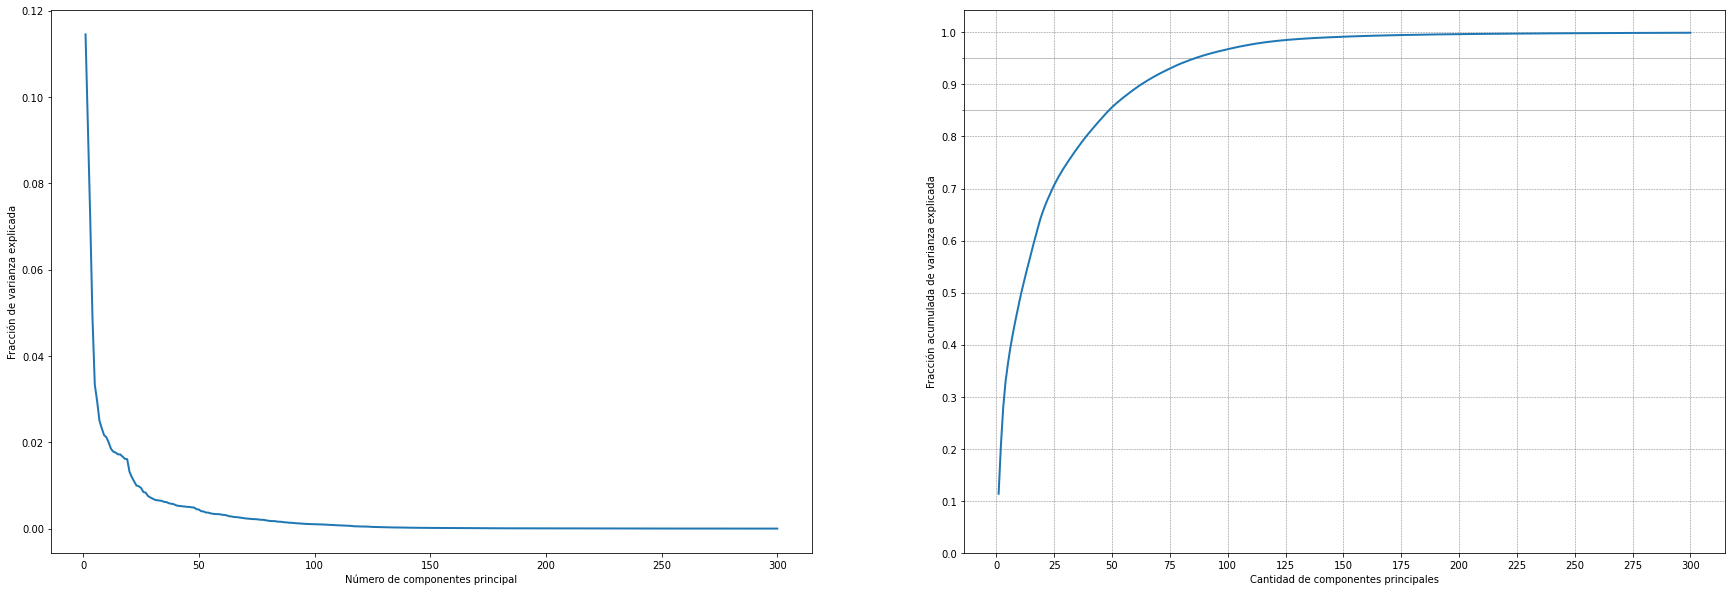

In [72]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (30, 10))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 2)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componentes principal')


# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)
ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 2)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

ax[1].set_xticks([i for i in range(0, 301, 25)], minor=False)
ax[1].set_yticks([i/100 for i in range(0, 110, 10)], minor=False)
ax[1].set_yticks([0.7, 0.85, 0.9, 0.95], minor=True)
ax[1].xaxis.grid(True, which='major')
ax[1].yaxis.grid(True, which='minor')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.show()

De lo anterior se observa que:
- Se considera 85% aprox. de los datos con 50 componenetes aproximadamente
- Se considera 90% aprox. de los datos con 63 componenetes aproximadamente
- Se considera 95% aprox. de los datos con 83 componenetes aproximadamente
- Se considera casi un 100% de los datos con 175 componenetes aproximadamente

En adelante, se utilizará un valor medio entre 90% y 95%, totalizando en 70 componentes para el PCA.

In [73]:
pca_85 = PCA(n_components = 50)
pca_85.fit(df_3)

PCA(n_components=50)

In [74]:
pca_90 = PCA(n_components = 70)
pca_90.fit(df_3)

PCA(n_components=70)

In [75]:
pca_99 = PCA(n_components = 175)
pca_99.fit(df_3)

PCA(n_components=175)

In [76]:
df_85 = pca_85.transform(df_3)

In [77]:
df_90 = pca_90.transform(df_3)

In [78]:
df_99 = pca_99.transform(df_3)

In [79]:
print(f"""Shapes para los datasets:
df 85: {df_85.shape}
df 90: {df_85.shape}
df 99: {df_85.shape}
""")

Shapes para los datasets:
df 85: (42416, 50)
df 90: (42416, 50)
df 99: (42416, 50)



# **Fase IV. Modeling**

## Clustering - KMeans

In [94]:
cluster_KMeans = KMeans(n_clusters=3)
cluster_KMeans.fit(df_85)

KMeans(n_clusters=3)

## Jerárquico Aglomerativo


In [164]:
cluster_Agglo = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [88]:
cluster_Agglo.fit_predict(df_85)

array([2, 2, 0, ..., 1, 0, 1], dtype=int64)

## DBSCAN

In [ ]:
cluster_DBSCAN = DBSCAN(eps=4.0, min_samples=2).fit(df_85)
cluster_DBSCAN.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN.labels_)
silhouette_coefficients_DBSCAN.append(score)

# **Fase V. Evaluation.**

## KMeans

In [81]:
from kneed import KneeLocator # importamos el paquete para detectar el codo

In [82]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 20):
  start = time.time()
  print(k)
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(df_85)
  sse.append(kkmeans.inertia_)
  end = time.time()
  print(f" Tiempo: {end-start}")

1
 Tiempo: 0.1850121021270752
2
 Tiempo: 0.3705167770385742
3
 Tiempo: 0.4038236141204834
4
 Tiempo: 0.5127441883087158
5
 Tiempo: 0.6135156154632568
6
 Tiempo: 0.9488475322723389
7
 Tiempo: 1.3494532108306885
8
 Tiempo: 1.5388176441192627
9
 Tiempo: 1.5205295085906982
10
 Tiempo: 1.7251019477844238
11
 Tiempo: 1.906923532485962
12
 Tiempo: 2.024836540222168
13
 Tiempo: 2.489306688308716
14
 Tiempo: 2.567373037338257
15
 Tiempo: 2.366098403930664
16
 Tiempo: 2.67110013961792
17
 Tiempo: 2.6914196014404297
18
 Tiempo: 3.1869568824768066
19
 Tiempo: 3.5410852432250977


Text(0, 0.5, 'SSE')

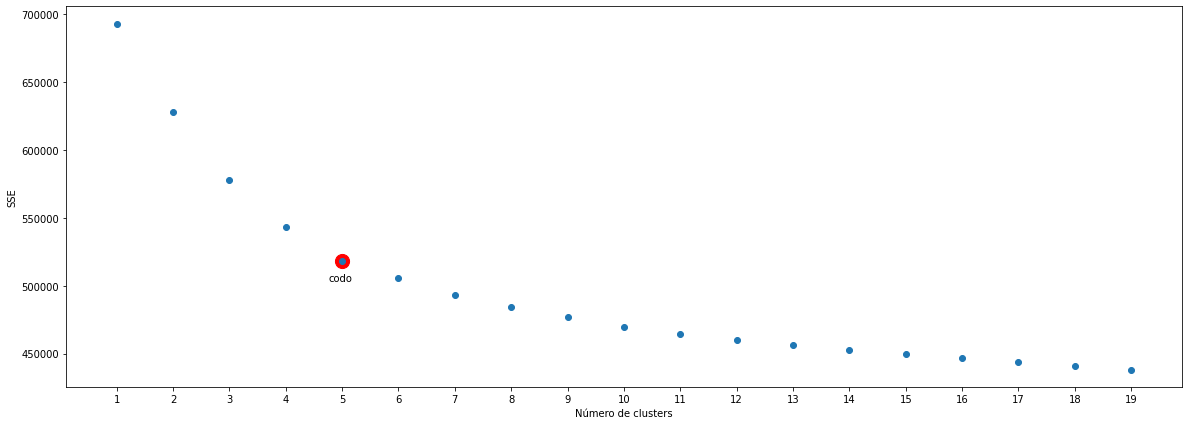

In [83]:
fig, ax = plt.subplots(figsize = (20, 7))

# elección de KneeLocator para el codo en este gráfico
ax.scatter(5, sse[4], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(4.75, sse[4]-15000, s="codo")       # agregamos un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SSEvsK
ax.scatter(range(1, 20), sse)            
ax.set_xticks(range(1, 20))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("SSE")

In [84]:
kl = KneeLocator(range(1, 20), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

El codo está en k = 5


In [91]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k
silhouette_coefficients_KMeans = []

# Se necesita tener al menos 2 clusters y a los sumo N-1 (con N el numero de muestras) para obtener coeficientes de Silohuette
for k in range(2, 20):
     cluster = KMeans(n_clusters=k)
     cluster.fit(df_85)
     score = silhouette_score(df_85, cluster.labels_)
     silhouette_coefficients_KMeans.append(score)

Text(0, 0.5, 'Promedio coeficientes de Silhouette')

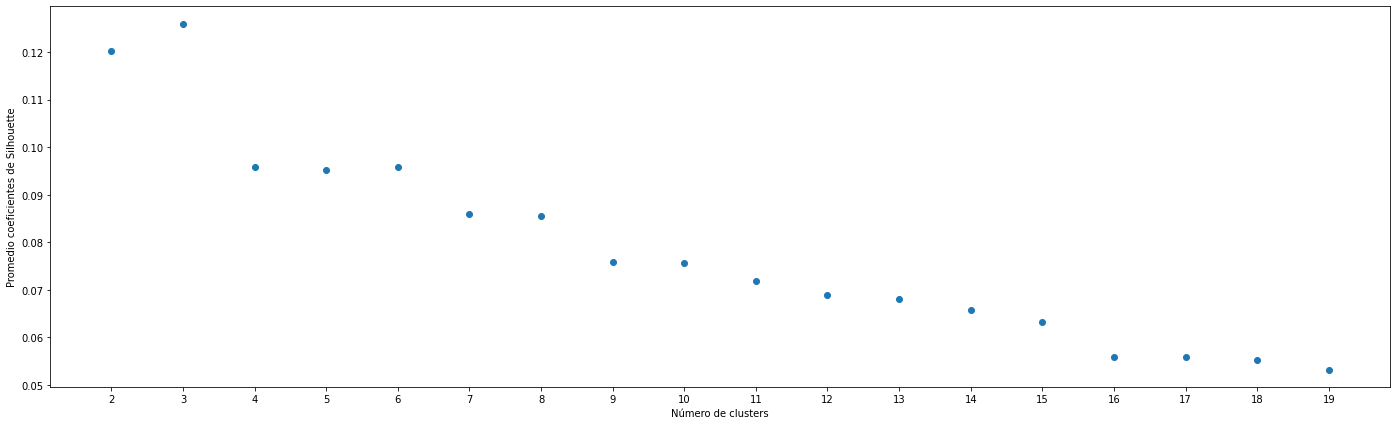

In [93]:
fig, ax = plt.subplots(figsize = (24, 7))

# estas lineas son el grafico de SSE vs K
ax.scatter(range(2, 20), silhouette_coefficients_KMeans)            
ax.set_xticks(range(2, 20))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("Promedio coeficientes de Silhouette")

## Aglomerativo

In [101]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k
silhouette_coefficients_Agglo = []

for k in range(2, 10):
  print(k)
  start = time.time()
  cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
  cluster.fit(df_85)
  score = silhouette_score(df_85, cluster.labels_)
  silhouette_coefficients_Agglo.append(score)
  end = time.time()
  print(f" Tiempo: {end-start}")

2
 Tiempo: 183.00482058525085
3
 Tiempo: 181.6179280281067
4
 Tiempo: 246.94239830970764
5
 Tiempo: 185.5557951927185
6
 Tiempo: 180.1534812450409
7
 Tiempo: 204.4413812160492
8
 Tiempo: 167.9702022075653
9
 Tiempo: 207.08736872673035


Text(0, 0.5, 'Promedio coeficientes de Silhouette')

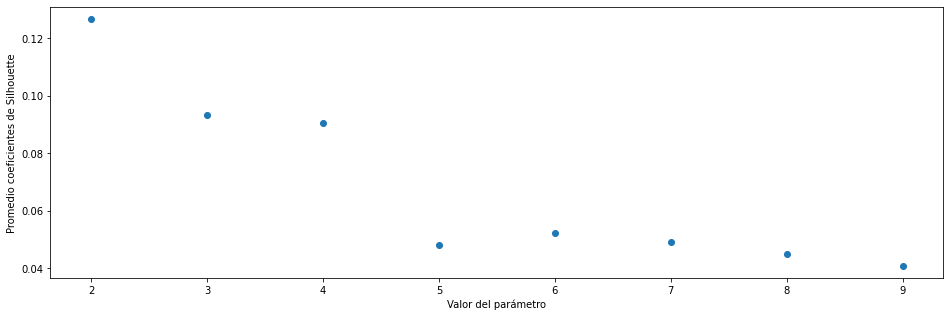

In [162]:
fig, ax = plt.subplots(figsize = (16, 5))

ax.scatter(range(2, 10), silhouette_coefficients_Agglo)            
ax.set_xticks(range(2, 10))
ax.set_xlabel("Valor del parámetro")
ax.set_ylabel("Promedio coeficientes de Silhouette")

## DBSCAN

In [172]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_85)
distances, indices = nbrs.kneighbors(df_85)

In [173]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

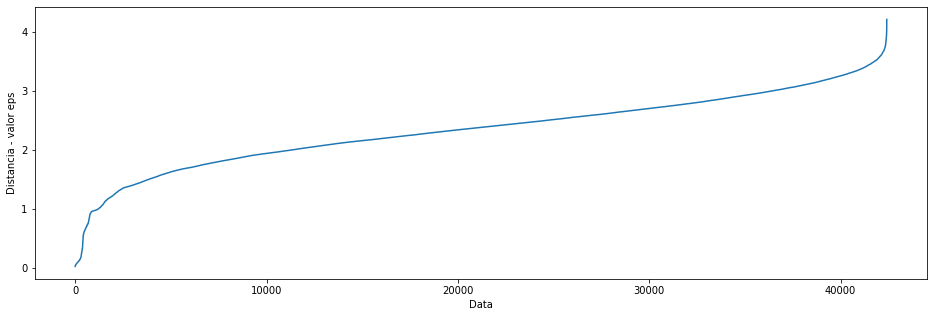

In [177]:
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(distances)
ax.set_xlabel("Data")
ax.set_ylabel("Distancia - valor eps")
plt.show()

In [131]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de parámetro
silhouette_coefficients_DBSCAN = []

parametros = [i/10 for i in range(1, 44, 7)]
# Aca no vamos ir variando el número de cluster. ¿POR QUE?
for i in parametros:
  print(f"Parámetro: {i}")
  start = time.time()
  try:
    cluster_DBSCAN = DBSCAN(eps=i, min_samples=2).fit(df_85)
    cluster_DBSCAN.fit(df_85)
    score = silhouette_score(df_85, cluster_DBSCAN.labels_)
    silhouette_coefficients_DBSCAN.append(score)
  except:
    print("Solo hay 1 label para este parámetro.")
  end = time.time()
  print(f" Tiempo: {end-start}")

cluster_DBSCAN = DBSCAN(eps=4.0, min_samples=2).fit(df_85)
cluster_DBSCAN.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN.labels_)
silhouette_coefficients_DBSCAN.append(score)

cluster_DBSCAN = DBSCAN(eps=4.1, min_samples=2).fit(df_85)
cluster_DBSCAN.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN.labels_)
silhouette_coefficients_DBSCAN.append(score)



Parámetro: 0.1
 Tiempo: 53.678088665008545
Parámetro: 0.8
 Tiempo: 53.05563497543335
Parámetro: 1.5
 Tiempo: 53.28481841087341
Parámetro: 2.2
 Tiempo: 50.99353098869324
Parámetro: 2.9
 Tiempo: 51.63973140716553
Parámetro: 3.6
 Tiempo: 54.04239892959595
Parámetro: 4.3
Solo hay 1 label para este parámetro.
 Tiempo: 36.599507570266724


Text(0, 0.5, 'Promedio coeficientes de Silhouette')

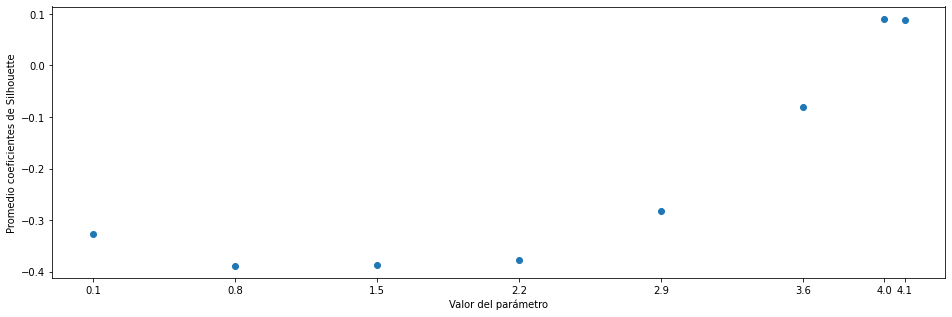

In [150]:
fig, ax = plt.subplots(figsize = (16, 5))

# estas lineas son el grafico de SSE vs el parámetro a variar
ax.scatter(parametros, silhouette_coefficients_DBSCAN)            
ax.set_xticks(parametros)
ax.set_xlabel("Valor del parámetro")
ax.set_ylabel("Promedio coeficientes de Silhouette")

### Parámetro min_samples

In [151]:
sil_score = []

In [152]:
cluster_DBSCAN_2 = DBSCAN(eps=4.0, min_samples=2).fit(df_85)
cluster_DBSCAN_2.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN_2.labels_)
sil_score.append(score)

In [153]:
cluster_DBSCAN_5 = DBSCAN(eps=4.0, min_samples=5).fit(df_85)
cluster_DBSCAN_5.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN_5.labels_)
sil_score.append(score)

In [154]:
cluster_DBSCAN_10 = DBSCAN(eps=4.0, min_samples=10).fit(df_85)
cluster_DBSCAN_10.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN_10.labels_)
sil_score.append(score)

In [160]:
cluster_DBSCAN_100 = DBSCAN(eps=4.0, min_samples=100).fit(df_85)
cluster_DBSCAN_100.fit(df_85)
score = silhouette_score(df_85, cluster_DBSCAN_100.labels_)
sil_score.append(score)

In [161]:
l = [2,5,10,100]
for i in range(0, len(l)):
  print(f"min_sample:{l[i]} score:{sil_score[i]}")
  

min_sample:2 score:0.09042412544791052
min_sample:5 score:0.09042412544791052
min_sample:10 score:0.09042412544791052
min_sample:100 score:0.08486486178150116


In [166]:
np.unique(cluster_DBSCAN_2.labels_)

array([-1,  0], dtype=int64)

# Análisis final

**Gracias al estudio y procesamiento de esta data, se entrenaron 3 modelos de aprendizaje no supervisado, siendos los parámetros de estos determinados mediante la visualización de sus scores de Silhoutte y el método del codo.**

**Los modelos fueron:**
- **KMeans, con 3 clusters. Notar que se observó diferenca entre la cantidad de clusters indicados por el método del codo y por Silhoutte siendo estas 5 y 3 respectivamente.**
- **Jerárquico aglomerativo, con 2 clusters, métrica euclidiana y linkage de 'ward'. Silhoutte indicó una cantidad de cluster ideal en 2.**
- **DBSCAN, con epsilon de 4.0 y min_samples de 2, entregando 2 clusters. Inicialmente se analizó qué pasaba para epsilon entre 0 y 1, encontrando que se obtenían mejores resultados a menor epsilon. Para solventar esto se utilizó NearestNeighbors, con el fin de identificar visualmente los posibles valores y se llegó a la curva ploteada. De esto se extrae que al tratar de encontrar el valor óptimo entre 0 y 1 estabamos sesgando nuestra búsqueda. En base a esto, se determinó finalmente el valor de epsilon en 4.0. Se hizo variar el parámetro min_samples entre 2, 5, 10 y 100 y se encontró que no había diferencia entre los 3 primeros pero que sí la había al saltar a 100, disminuyendo su valor. Se fijó el valor arbitrariamente en 2.**
- **Notar que al encontrar k=3 en KMeans, estamos indicando que existen 3 perfiles de personas en la data. Para saber a qué se refiere de manera explícita sería necesario tranformar de vuelta desde los PCA. El análisis es análogo al modelo Jerárquico y DBSCAN, encontrando 2 perfiles de personas para estos.**

---
                                                        Fin Prueba 3
---